### Introducción

* Este notebook ofusca las entidades detectadas por **comprehend** sobre una imagen cuyo texto se extrae mediante **textract**, permitiendo tambien que un humano las supervise y las modifique facilmente, y generando un dataset que permita el reentrenamiento del modelo.

#### imports

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
import os 
import pandas as pd
from PIL import Image, ImageDraw
import re

import boto3
REGION = 'eu-west-1'

#### cargar credenciales desde ficherlo local

In [82]:
credenciales_brais = pd.read_csv('rootkey.csv')
f = open('rootkey.csv', "r")
credenciales_brais = f.read().split('\n')

ACCESS_KEY = credenciales_brais[0].split('=')[1]
SECRET_KEY = credenciales_brais[1].split('=')[1]

## nombre imagen a ofuscar:
* a continuación proporcionamos el nombre de la imagen que vamos a tratar, y que está ubicada en S3

In [84]:
nombre_imagen = 'texto1.PNG'

# Descargar imagen de S3 

In [85]:
s3 = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY, 
    region_name='eu-west-1'
)

In [86]:
print('Existing buckets:')
for bucket in s3.list_buckets()['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  pruebas.ner


In [87]:
nombre_bucket = 'pruebas.ner'
    if not os.path.isfile(nombre_imagen):
s3.download_file(nombre_bucket, nombre_imagen, nombre_imagen)

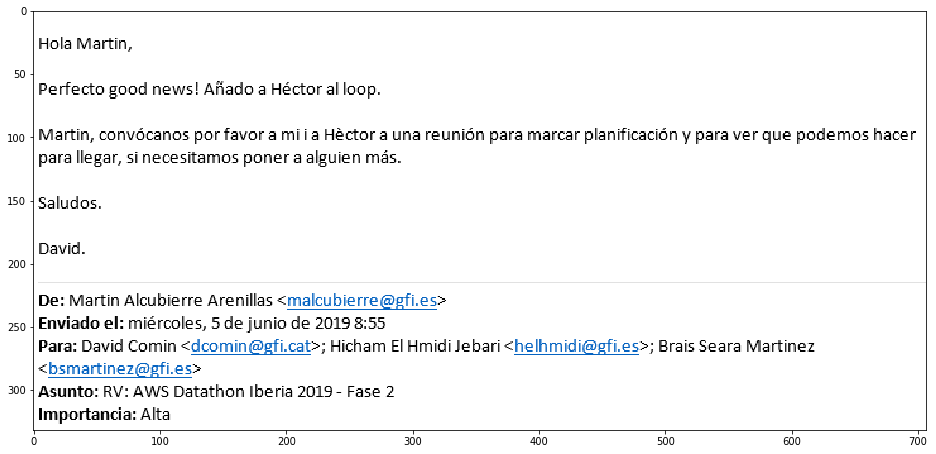

In [88]:
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(plt.imread(nombre_imagen, format='png'), aspect='equal')

# Prueba textract

In [90]:
textract = boto3.client(
    'textract',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY, 
    region_name='eu-west-1'
)

In [91]:
output_textract = textract.detect_document_text(
Document={
        'S3Object': {
            'Bucket': 'pruebas.ner',
            'Name': nombre_imagen
        }
    }
)

In [92]:
output_textract['Blocks'][15]

{'BlockType': 'WORD',
 'Confidence': 99.93276977539062,
 'Text': 'Martin,',
 'Geometry': {'BoundingBox': {'Width': 0.06585083901882172,
   'Height': 0.042942844331264496,
   'Left': 0.047494955360889435,
   'Top': 0.06187774986028671},
  'Polygon': [{'X': 0.047494955360889435, 'Y': 0.06187774986028671},
   {'X': 0.11334579437971115, 'Y': 0.06187774986028671},
   {'X': 0.11334579437971115, 'Y': 0.10482059419155121},
   {'X': 0.047494955360889435, 'Y': 0.10482059419155121}]},
 'Id': '47667327-634c-4192-8d2f-43f0b8f62e63'}

# Obtener texto completo de textract

In [96]:
texto_completo = ""
BlockType = "LINE"
i = 1
n_lineas = -1
while BlockType == "LINE":
    n_lineas = n_lineas + 1
    texto_completo = texto_completo + output_textract['Blocks'][i]['Text'] + "\n"
    BlockType = output_textract['Blocks'][i]['BlockType']
    i = i + 1
texto_completo = texto_completo[0:(len(texto_completo)-len(texto_completo.split()[len(texto_completo.split())-1]))-1]
print(texto_completo)

Hola Martin,
Perfecto good news! Afado a Hector al loop.
Martin, convocanos por favor a mi i a Hector a una reunion para marcar planificacion y para ver que podemos
hacer
para llegar, si necesitamos poner a alguien mas.
Saludos.
David.
De: Martin Alcubierre Arenillas <malcubierre @gfi.es>
Enviado el: miercoles, 5 de junio de 2019 8:55
Para: David Comin <dcomin@gfi.cat>; Hicham El Hmidi Jebari <helhmidi@gfi.es>; Brais Seara Martinez
<bsmartinez@gfi.es>
Asunto: RV: AWS Datathon iberia 2019 - Fase 2
Importancia: Alta



In [153]:
n_lineas

13

# Aplicar comprehend

* Aquí usamos la API de comprehend con su modelo por defecto, que detecta entidades de tipo PERSON, LOCATION, DATE y OTHER

In [98]:
comprehend = boto3.client(
    'comprehend',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY, 
    region_name='eu-west-1'
)

In [99]:
output_comprehend = comprehend.detect_entities( 
    LanguageCode='es',    
    Text=texto_completo,
    )

In [100]:
entidades = output_comprehend['Entities']
entidades[1]

{'Score': 0.9718290567398071,
 'Type': 'PERSON',
 'Text': 'Hector',
 'BeginOffset': 41,
 'EndOffset': 47}

In [158]:
def marcar_entidades(entidades, ocultar = False, dp = True):
    texto = texto_completo
    def tag_to_background_color_en(argument):
        if ocultar == True:
            switcher = {
                'PERSON' : 'black',
                'LOCATION' : 'black',
                'OTHER' : 'black',
                'DATE' : 'white'
            }
        else:
            switcher = {
                'PERSON' : 'red',
                'LOCATION' : 'orange',
                'OTHER' : 'yellow',
                'DATE' : 'white'
        }
        return switcher.get(argument, "white")

    html = texto[0:entidades[0]['BeginOffset']]+'<span style = "background-color: ' + tag_to_background_color_en(entidades[0]['Type']) + ';">' + texto[entidades[0]['BeginOffset']:entidades[0]['EndOffset']] + '</span>'
    for i in range(1,len(entidades)):
        html = html + texto[entidades[i-1]['EndOffset']:entidades[i]['BeginOffset']] + '<span style = "background-color: ' + tag_to_background_color_en(entidades[i]['Type']) + ';">' + texto[entidades[i]['BeginOffset']:entidades[i]['EndOffset']] + '</span>'
    html = html + texto[entidades[len(entidades)-1]['EndOffset']:len(texto)]
    html = html.replace("\n"," <br>")  # el espacio antes de <br> es importante porque comprened cuenta \n como 2
    if dp == True:
        display(HTML(html))
    return html

# guardamos el html para después
html = marcar_entidades(entidades, False)

# Obtener indice de palabra por posicion de caracteres
* En este paso definimos un método que soluciona el problema de que comprehend devuelve posiciones de caracteres mientras que textract devuelve bloques ordenados de palabras
* De este modo, podremos utilizar ambos resultados conjuntamente para ofuscar las entidades encima de la propia imagen 

In [103]:
indice_palabra = 5
output_textract['Blocks'][n_lineas + indice_palabra]

{'BlockType': 'WORD',
 'Confidence': 59.93553924560547,
 'Text': 'news!',
 'Geometry': {'BoundingBox': {'Width': 0.05700817331671715,
   'Height': 0.0392625518143177,
   'Left': 0.13241243362426758,
   'Top': 0.16872864961624146},
  'Polygon': [{'X': 0.13241243362426758, 'Y': 0.16872864961624146},
   {'X': 0.18942059576511383, 'Y': 0.16872864961624146},
   {'X': 0.18942059576511383, 'Y': 0.20799119770526886},
   {'X': 0.13241243362426758, 'Y': 0.20799119770526886}]},
 'Id': '8536dd41-dd35-45e9-b998-fbaec0480a2b'}

In [104]:
texto_completo

'Hola Martin,\nPerfecto good news! Afado a Hector al loop.\nMartin, convocanos por favor a mi i a Hector a una reunion para marcar planificacion y para ver que podemos\nhacer\npara llegar, si necesitamos poner a alguien mas.\nSaludos.\nDavid.\nDe: Martin Alcubierre Arenillas <malcubierre @gfi.es>\nEnviado el: miercoles, 5 de junio de 2019 8:55\nPara: David Comin <dcomin@gfi.cat>; Hicham El Hmidi Jebari <helhmidi@gfi.es>; Brais Seara Martinez\n<bsmartinez@gfi.es>\nAsunto: RV: AWS Datathon iberia 2019 - Fase 2\nImportancia: Alta\n'

In [105]:
i_entidad = 5
texto_completo[entidades[i_entidad]['BeginOffset']:entidades[i_entidad]['EndOffset']]

'Martin Alcubierre'

In [106]:
inicial= 13
final = 21
texto_completo[inicial:final]

'Perfecto'

In [107]:
posicion_caracter_inicial = inicial
texto_completo[posicion_caracter_inicial:(posicion_caracter_inicial+len(texto_completo[posicion_caracter_inicial:].split()[0]))]

'Perfecto'

In [108]:
def Palabra_por_posicion_caracter_inicial(posicion_caracter_inicial):
    return texto_completo[posicion_caracter_inicial:(posicion_caracter_inicial+len(texto_completo[posicion_caracter_inicial:].split()[0]))]
Palabra_por_posicion_caracter_inicial(posicion_caracter_inicial)

'Perfecto'

In [109]:
def Indice_palabra_por_posicion_caracter_inicial(posicion_caracter_inicial):
    splitted_texto = re.split('\n| ',texto_completo)
    posicion_caracter_inicial = posicion_caracter_inicial
    contador_posiciones_caracteres = 0
    indice_palabra = 0
    primero = True
    while contador_posiciones_caracteres < posicion_caracter_inicial:
        contador_posiciones_caracteres = contador_posiciones_caracteres + len(splitted_texto[indice_palabra])
        if primero == True:
            primero = False
        else:
            contador_posiciones_caracteres = contador_posiciones_caracteres + 1
        indice_palabra = indice_palabra + 1
    return indice_palabra 
output_textract['Blocks'][Indice_palabra_por_posicion_caracter_inicial(inicial) + n_lineas]['Text']

'Perfecto'

# Ofuscar en la propia Imagen el resultado de comprehend

* Ahora, podemos ya usar la información que no devuelve textract para ocultar las entidades sobre una copia de la imagen original.
* textract nos proporciona las coordenadas de cuatro vértices alrededor de cada palabra, que son las que usaremos para dibujar el rectángulo que oculte las entidades marcadas

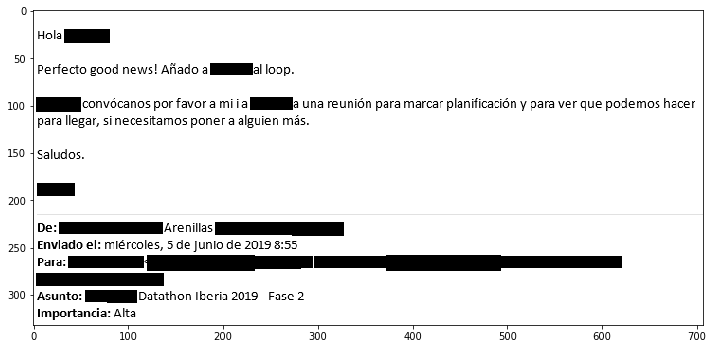

In [110]:
def ofuscar_imagen(entidades):
    
    im = Image.open(nombre_imagen)

    xpixels = im.size[0]
    ypixels = im.size[1]

    i_ = 0  # este contador es por las entidades que tienen más de una palabra

    for i in range(0,len(entidades)):
    
        n_tokens_entidad = len(entidades[i_]['Text'].split())
        
        dr = ImageDraw.Draw(im)
    
        if entidades[i_]['Type'] not in ('PERSON','OTHER','LOCATION') :
            i_ = i_+ 1
            continue
    
        j0_bloque = Indice_palabra_por_posicion_caracter_inicial(entidades[i_]['BeginOffset']) + n_lineas
        
        for j_bloque in range(j0_bloque,j0_bloque + n_tokens_entidad):          

            pol = output_textract['Blocks'][j_bloque]['Geometry']['Polygon']

            a = (pol[0]['X']*(xpixels), pol[0]['Y']*(ypixels))
            b = (pol[1]['X']*(xpixels), pol[1]['Y']*(ypixels))
            c = (pol[2]['X']*(xpixels), pol[2]['Y']*(ypixels))
            d = (pol[3]['X']*(xpixels), pol[3]['Y']*(ypixels))

            dr.polygon([a, b, c, d, a], fill='black')
        
        i_ = i_+ 1
    im.save("ofuscadas/" + nombre_imagen.split(".")[0] + "_ofuscada.PNG", "PNG")
    fig, ax = plt.subplots(1, figsize=(12, 7))
    plt.imshow(im)

ofuscar_imagen(entidades)

# Corregir a comprehend

* En este apartado hacemos uso de **JavaScript** para lograr una forma cómoda de corregir de manera manual el resultado de comprehend, añadiendo etiquetas a palabras del texto o suprimiéndolas

In [111]:
from IPython.display import Javascript
file = open(nombre_imagen.split(".")[0] + ".txt", "w")
file.write(texto_completo) 
file.close()

In [112]:
def insertar_entidad_en_su_sitio(entidad):
    ini_new = entidad['BeginOffset']
    end_new = entidad['EndOffset']
    for i in range(0,len(entidades_)-1):
        ini_old = entidades_[i]['BeginOffset']
        ini_old_next = entidades_[i+1]['BeginOffset']
        end_old = entidades_[i]['EndOffset']
        
        if ini_new <= ini_old and end_new >= end_old:
            del entidades_[i]
            entidades_.insert(i, entidad)
            return
        elif ini_new > end_old-1 and end_new < ini_old_next:
            entidades_.insert(i+1, entidad)
            return    
    entidades_.append(entidad)
    
def eliminar_entidad(ini,end):
    for i in range(0,len(entidades_)):
        if entidades_[i]['BeginOffset'] >= ini and entidades_[i]['EndOffset'] <= end:
            del entidades_[i]
            i = i - 1       

In [113]:
def set_html():
    js_file = open("js_Corregir.html","r")
    js = js_file.read()
    html = marcar_entidades(entidades_, ocultar = False, dp = False)
    js = js.replace("[MI_TEXTO]",html)  # espacio antes de <br> !! 
    js = re.sub(r'(?!<\/span>|<br>|<\/button>|<span style = "background-color:|<div>|<\/div>|<div id|<\/p>|<button style|<\/script>|<\/body>|<\/html>|<html>|<body>|<meta |<script)(<)',r'&lt',js)
    #c_except = [r'(?<!<\/span>|<\/html>|<br>|;">|<div>|<\/div>|     >|<\/button>|<div id|<button style|<\/script>|<\/body>|<\/html|<html>|<body>|"utf-8">|Javascript">|txt.length >|<\/p>)']
    #c_out = [">"]
    #rx = r"(?<!\b{0})({1})".format(r")(?<!\b".join(c_except), "|".join(c_out))
    #js = re.sub(rx, lambda m: m.group(1) if m.group(1) else r'&gt',js)
                 
    temp_file = open("temp.html","w")
    temp_file.write(js) 
    temp_file.close()

In [114]:
entidades_ = entidades.copy()

### Celda Interactiva 

* Esta celda permite **seleccionar texto con el ratón** y marcarlo o desmarcarlo usando **botones** de HTML. 
* Automáticamente, nos devuelve el texto con los cambios, y en la casilla de abajo, la imagen con las nuevas entidades ofuscadas.
* También genera una nueva lista de python con las nuevas entidades, que usaremos más abajo para generar un nuevo conjunto de ***annotations*** que se podría usar para entrenar un modelo de comprehend.

In [150]:
set_html()
HTML(open("temp.html").read())

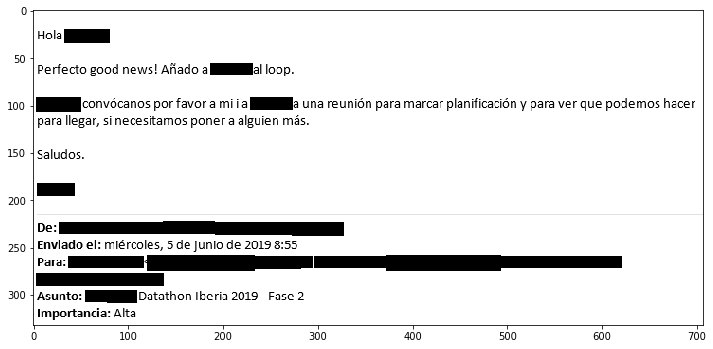

In [151]:
ofuscar_imagen(entidades_)

# Generar Annotations List

* Una vez corregido el resultado de comprehend a mano, tenemos un nuevo set de entidades marcadas en su contexto, que involucra la supervisión de un humano. Esta nueva información es útil y costosa de obtener, por lo que es importante que podamos aprovecharla.
* En este apartado alimentamos con las entidades obtenidas un dataset de ***annotations***, que pueda servir para afinar el modelo automático de comprehend.
* Este dataset hace referencia a la posición relativa de cada entidad en su correspondiente texto y línea, siguiendo el formato que exige comprehend para sus datasets de entrenamiento mediante annotations.

#### Obtener linea de las Entidades y Offsets relativos a la linea

In [140]:
entidades_relativo_lineas = [] #  python pasa por referencia los elementos de una lista pasada por valor
for i in range(0,len(entidades_)):
    entidades_relativo_lineas.append(entidades_[i].copy()) 
texto_splitted = texto_completo.split("\n")
for i in range(0,len(entidades_.copy())):
    entidades_relativo_lineas[i]['Line'] = texto_completo.count("\n", 0, entidades_.copy()[i]['BeginOffset'])
    line_offset  = 0
    for l in range(0,entidades_relativo_lineas[i]['Line']):
        line_offset = line_offset + len(texto_splitted[l]) + 1
    if i > 0:
        entidades_relativo_lineas[i]['BeginOffset'] = entidades_[i].copy()['BeginOffset'] - line_offset
        entidades_relativo_lineas[i]['EndOffset'] = entidades_[i].copy()['EndOffset'] - line_offset
entidades_relativo_lineas[5]

{'Score': 1,
 'Type': 'PERSON',
 'Text': 'Martin Alcubierre Arenillas',
 'BeginOffset': 4,
 'EndOffset': 31,
 'Line': 7}

#### Escribir annotations

In [141]:
import csv 
if not os.path.isfile("annotations.csv"):
    f = open("annotations.csv", "x")
    f.close()
    with open("annotations.csv", "w", encoding="utf-8") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["File", "Line", "Begin Offset", "End Offset", "Type"])
        for entidad in entidades_relativo_lineas:
            csv_writer.writerow([nombre_imagen, entidad["Line"], entidad["BeginOffset"], entidad["EndOffset"], entidad["Type"]])
else:
    with open("annotations.csv", "a", encoding="utf-8") as csv_file:
        csv_writer = csv.writer(csv_file)
        for entidad in entidades_relativo_lineas:
            csv_writer.writerow([nombre_imagen, entidad["Line"], entidad["BeginOffset"], entidad["EndOffset"], entidad["Type"]])

In [142]:
pd.read_csv("annotations.csv").head(10)

,File,Line,Begin Offset,End Offset,Type
0,texto1.PNG,0,5,11,PERSON
1,texto1.PNG,1,28,34,PERSON
2,texto1.PNG,2,0,6,PERSON
3,texto1.PNG,2,38,44,PERSON
4,texto1.PNG,6,0,5,PERSON
5,texto1.PNG,7,4,21,PERSON
6,texto1.PNG,7,33,52,OTHER
7,texto1.PNG,8,12,41,DATE
8,texto1.PNG,8,42,46,DATE
9,texto1.PNG,9,6,17,PERSON


### Fin